In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from DataGenerator2D import DataGenerator2D
from Models import Resunetpp
from Evaluation_matrices import iou, f1, dice_coef, dice_coef_loss
from Federated import scale_model_weights, sum_scaled_weights

In [3]:
#initialize global model
Resunetpp = Resunetpp()
global_model = Resunetpp.build_model()
comms_round = 100
opt = tf.keras.optimizers.Adam(1e-3)
metrics = [f1, iou , dice_coef ]
global_model.compile(loss=dice_coef_loss,
                      optimizer=opt,
                      metrics=metrics)
global_model.summary()
global_mat = []
client_1 = DataGenerator2D('//PATH TO FIRST CLIENT TRAINING DATA//', img_size=256, batch_size=8, shuffle=True)
client_2 = DataGenerator2D('//PATH TO SECOND CLIENT TRAINING DATA//', img_size=256, batch_size=8, shuffle=True)
client_3 = DataGenerator2D('//PATH TO THIRD CLIENT TRAINING DATA//', img_size=256, batch_size=8, shuffle=True)
test = DataGenerator2D('//PATH TO YOUR TEST DATA//', img_size=256, batch_size=35, shuffle=True)
clients = [client_1,client_2,client_3]



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_37 (BatchN  (None, 256, 256, 16  64         ['conv2d_41[0][0]']              
 ormalization)                  )                                                           

 activation_26 (Activation)     (None, 128, 128, 32  0           ['batch_normalization_42[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_47 (Conv2D)             (None, 64, 64, 64)   18496       ['activation_26[0][0]']          
                                                                                                  
 batch_normalization_43 (BatchN  (None, 64, 64, 64)  256         ['conv2d_47[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_27 (Activation)     (None, 64, 64, 64)   0           ['batch_normalization_43[0][0]'] 
                                                                                                  
 conv2d_49

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_51 (BatchN  (None, 32, 32, 256)  1024       ['conv2d_56[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_16 (Add)                   (None, 32, 32, 256)  0           ['batch_normalization_48[0][0]', 
                                                                  'batch_normalization_49[0][0]', 
                                                                  'batch_normalization_50[0][0]', 
                                                                  'batch_normalization_51[0][0]'] 
                                                                                                  
 batch_nor

                                                                                                  
 activation_35 (Activation)     (None, 128, 128, 32  0           ['batch_normalization_58[0][0]'] 
                                )                                                                 
                                                                                                  
 batch_normalization_59 (BatchN  (None, 64, 64, 128)  512        ['multiply_15[0][0]']            
 ormalization)                                                                                    
                                                                                                  
 conv2d_64 (Conv2D)             (None, 128, 128, 12  36992       ['activation_35[0][0]']          
                                8)                                                                
                                                                                                  
 activatio

                                                                                                  
 conv2d_70 (Conv2D)             (None, 256, 256, 64  9280        ['activation_40[0][0]']          
                                )                                                                 
                                                                                                  
 activation_41 (Activation)     (None, 128, 128, 64  0           ['batch_normalization_65[0][0]'] 
                                )                                                                 
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 64  0          ['conv2d_70[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_71

 conv2d_79 (Conv2D)             (None, 256, 256, 16  4624        ['multiply_19[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization_70 (BatchN  (None, 256, 256, 16  64         ['conv2d_76[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_71 (BatchN  (None, 256, 256, 16  64         ['conv2d_77[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_72 (BatchN  (None, 256, 256, 16  64         ['conv2d_78[0][0]']              
 ormalizat

In [3]:
lr = 1e-3
counter = 0
best_performance = float('inf')
#commence global training loop
for comm_round in range(comms_round):
    print("---------------------------------------------------------------------------------------")
    print("Epoch ", comm_round )
    print("---------------------------------------------------------------------------------------")
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #loop through each client and create new local model
    for client in clients:
        local_model = Resunetpp.build_model() 
        opt = tf.keras.optimizers.Adam(lr)
        metrics = [f1, iou , dice_coef ]

        local_model.compile(loss=dice_coef_loss,
                      optimizer=opt,
                      metrics=metrics)
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(client, epochs=1 ,verbose=1,steps_per_epoch=30)
        
        #scale the model weights and add to list
        scaling_factor = 1/3
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
    print("Performance Matrix ")
    #process and batch the test set 
    global_performance = global_model.evaluate(
                                    test,
                                    batch_size= 60, 
                                    verbose=1,
                                    )
    if(best_performance<=global_performance[0]):
        counter = counter + 1
    else:
        global_model.save_weights('//PATH TO SAVE YOUR FEDERATED WEIGHTS//')
        print("Model loss imporved from", best_performance, "to",global_performance[0] )
        print(r"Model Saved in //PATH TO SAVE YOUR FEDERATED WEIGHTS//")
        best_performance = global_performance[0]
        counter = 0
    
    if(counter == 5):
        print("loss didn't imporve, so LR reduced from", lr, "to",lr*0.5 )
        lr=lr*0.5
        counter = 0
        
    global_mat.append(global_performance)
    print("---------------------------------------------------------------------------------------")


---------------------------------------------------------------------------------------
Epoch  0
---------------------------------------------------------------------------------------
30/30 [==============================] - 18s 467ms/step - loss: 0.7496 - f1: 0.2583 - iou: 0.1464 - dice_coef: 0.2504
Performance Matrix 
11/11 [==============================] - 13s 884ms/step - loss: 0.9343 - f1: 0.0000e+00 - iou: 0.0338 - dice_coef: 0.0653
Model loss imporved from inf to 0.9342888593673706
Model Saved in E:\NU\Grad\TuSimple\training\clients\Models\ResunetppGlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  1
---------------------------------------------------------------------------------------
30/30 [==============================] - 18s 460ms/step - loss: 0.5458 - f1: 0.4809 - iou: 0.3004 - dice_coef: 0.4558
Performance Matrix 
11/11 [=

30/30 [==============================] - 15s 367ms/step - loss: 0.1375 - f1: 0.8654 - iou: 0.7811 - dice_coef: 0.8625
Performance Matrix 
11/11 [==============================] - 8s 619ms/step - loss: 0.4718 - f1: 0.5204 - iou: 0.3749 - dice_coef: 0.5161
Model loss imporved from 0.6851428747177124 to 0.4718315899372101
Model Saved in E:\NU\Grad\TuSimple\training\clients\Models\ResunetppGlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  11
---------------------------------------------------------------------------------------
30/30 [==============================] - 15s 353ms/step - loss: 0.1281 - f1: 0.8772 - iou: 0.8063 - dice_coef: 0.8744
Performance Matrix 
11/11 [==============================] - 8s 630ms/step - loss: 0.3425 - f1: 0.6509 - iou: 0.5057 - dice_coef: 0.6496
Model loss imporved from 0.4718315899372101 to 0.3424981832504272

30/30 [==============================] - 15s 360ms/step - loss: 0.0814 - f1: 0.9207 - iou: 0.8773 - dice_coef: 0.9186
Performance Matrix 
11/11 [==============================] - 8s 614ms/step - loss: 0.1240 - f1: 0.8677 - iou: 0.7918 - dice_coef: 0.8701
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  20
---------------------------------------------------------------------------------------
30/30 [==============================] - 15s 354ms/step - loss: 0.0826 - f1: 0.9205 - iou: 0.8816 - dice_coef: 0.9210
Performance Matrix 
11/11 [==============================] - 8s 619ms/step - loss: 0.1011 - f1: 0.8906 - iou: 0.8292 - dice_coef: 0.8928
Model loss imporved from 0.1154252141714096 to 0.10113926231861115
Model Saved in E:\NU\Grad\TuSimple\training\clients\Models\ResunetppGlobalWeights.h5
----------------------------------------------------------------

30/30 [==============================] - 15s 350ms/step - loss: 0.0345 - f1: 0.9658 - iou: 0.9600 - dice_coef: 0.9655
Performance Matrix 
11/11 [==============================] - 8s 616ms/step - loss: 0.0612 - f1: 0.9326 - iou: 0.9071 - dice_coef: 0.9353
Model loss imporved from 0.06550391763448715 to 0.06120438873767853
Model Saved in E:\NU\Grad\TuSimple\training\clients\Models\ResunetppGlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  40
---------------------------------------------------------------------------------------
30/30 [==============================] - 14s 344ms/step - loss: 0.0152 - f1: 0.9867 - iou: 1.0013 - dice_coef: 0.9862
Performance Matrix 
11/11 [==============================] - 8s 610ms/step - loss: 0.0653 - f1: 0.9278 - iou: 0.8978 - dice_coef: 0.9316
---------------------------------------------------------------

30/30 [==============================] - 15s 362ms/step - loss: 0.0134 - f1: 0.9862 - iou: 1.0016 - dice_coef: 0.9866
Performance Matrix 
11/11 [==============================] - 8s 612ms/step - loss: 0.0746 - f1: 0.9175 - iou: 0.8806 - dice_coef: 0.9210
loss didn't imporve, so LR reduced from 0.001 to 0.0005
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  50
---------------------------------------------------------------------------------------
30/30 [==============================] - 14s 353ms/step - loss: 0.0024 - f1: 0.9976 - iou: 1.0233 - dice_coef: 0.9976
Performance Matrix 
11/11 [==============================] - 8s 612ms/step - loss: 0.0539 - f1: 0.9379 - iou: 0.9174 - dice_coef: 0.9412
---------------------------------------------------------------------------------------
------------------------------------------------------------------------

30/30 [==============================] - 15s 349ms/step - loss: -0.0089 - f1: 1.0074 - iou: 1.0491 - dice_coef: 1.0089
Performance Matrix 
11/11 [==============================] - 8s 616ms/step - loss: 0.0439 - f1: 0.9493 - iou: 0.9383 - dice_coef: 0.9526
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  60
---------------------------------------------------------------------------------------
30/30 [==============================] - 15s 361ms/step - loss: -0.0015 - f1: 1.0017 - iou: 1.0350 - dice_coef: 1.0015
Performance Matrix 
11/11 [==============================] - 8s 612ms/step - loss: 0.0381 - f1: 0.9559 - iou: 0.9500 - dice_coef: 0.9590
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  61
----------------------------

30/30 [==============================] - 14s 343ms/step - loss: -0.0504 - f1: 1.0513 - iou: 1.1340 - dice_coef: 1.0504
Performance Matrix 
11/11 [==============================] - 8s 623ms/step - loss: 0.0379 - f1: 0.9566 - iou: 0.9550 - dice_coef: 0.9599
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  70
---------------------------------------------------------------------------------------
30/30 [==============================] - 14s 344ms/step - loss: -0.0510 - f1: 1.0501 - iou: 1.1356 - dice_coef: 1.0510
Performance Matrix 
11/11 [==============================] - 8s 613ms/step - loss: 0.0373 - f1: 0.9571 - iou: 0.9555 - dice_coef: 0.9602
Model loss imporved from 0.03741118311882019 to 0.03727694973349571
Model Saved in E:\NU\Grad\TuSimple\training\clients\Models\ResunetppGlobalWeights.h5
-------------------------------------------------------------

30/30 [==============================] - 14s 342ms/step - loss: -0.0539 - f1: 1.0540 - iou: 1.1429 - dice_coef: 1.0539
Performance Matrix 
11/11 [==============================] - 8s 604ms/step - loss: 0.0376 - f1: 0.9567 - iou: 0.9548 - dice_coef: 0.9598
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  80
---------------------------------------------------------------------------------------
30/30 [==============================] - 14s 342ms/step - loss: -0.0552 - f1: 1.0568 - iou: 1.1438 - dice_coef: 1.0552
Performance Matrix 
11/11 [==============================] - 8s 605ms/step - loss: 0.0361 - f1: 0.9583 - iou: 0.9596 - dice_coef: 0.9614
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  81
----------------------------

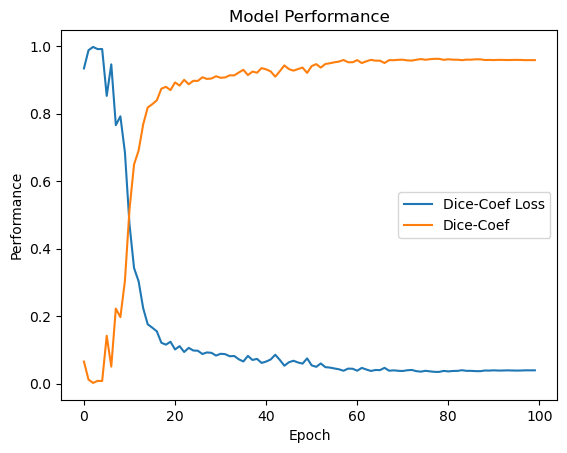

In [4]:
performance_matrix = list(map(list, zip(*global_mat)))
plt.plot(performance_matrix[0])
plt.plot(performance_matrix[3])
plt.title('Model Performance')
plt.ylabel('Performance')
plt.xlabel('Epoch')
plt.legend(['Dice-Coef Loss', 'Dice-Coef'])
plt.show()

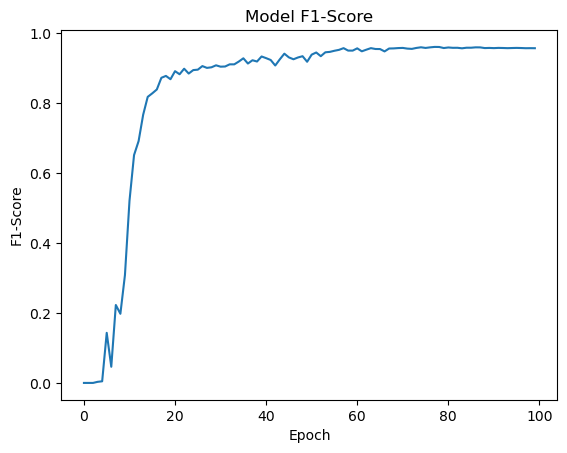

In [5]:
plt.plot(performance_matrix[1])
plt.title('Model F1-Score')
plt.ylabel('F1-Score')
plt.xlabel('Epoch')
plt.show()

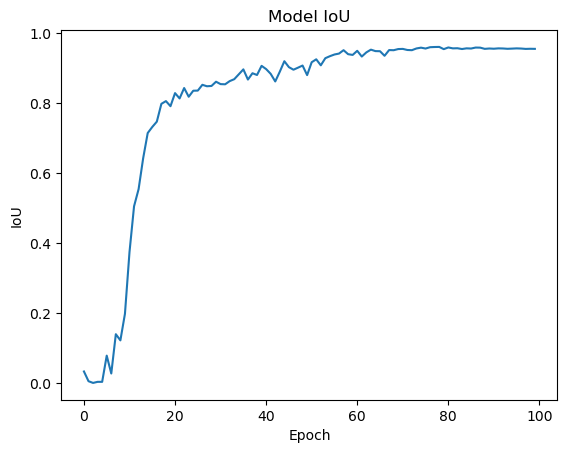

In [6]:
plt.plot(performance_matrix[2])
plt.title('Model IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.show()

In [4]:
val_generator = DataGenerator2D('//PATH TO YOUR TEST DATA//', img_size=256,batch_size=128, shuffle=True)
global_model = Resunetpp.build_model()
global_model.load_weights('//PATH TO YOUR FEDERATED RESUNET++ MODEL WEIGHTS.h5//')
global_model.compile(loss=dice_coef_loss,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=[f1, iou , dice_coef ])
evaluate = global_model.evaluate(val_generator,batch_size= 60, verbose=1,)

3/3 [==============================] - 23s 5s/step - loss: 0.0346 - f1: 0.9606 - iou: 0.9631 - dice_coef: 0.9639


In [5]:
X, y = val_generator.__getitem__(0)
predict = global_model.predict(X)

4/4 [==============================] - 3s 275ms/step


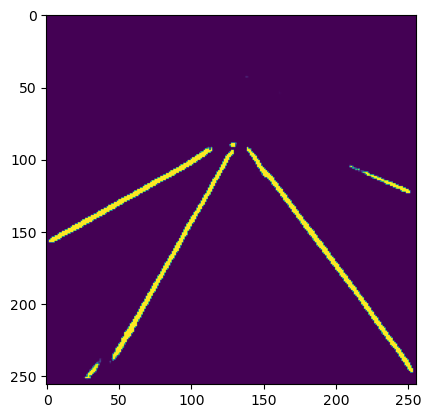

In [6]:
img = predict[2]
plt.imshow(img)

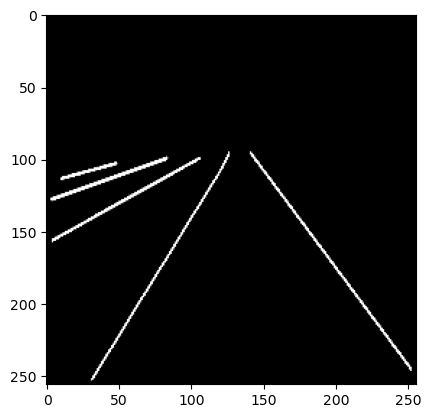

In [7]:
img1 = y[2]
plt.imshow(img1)

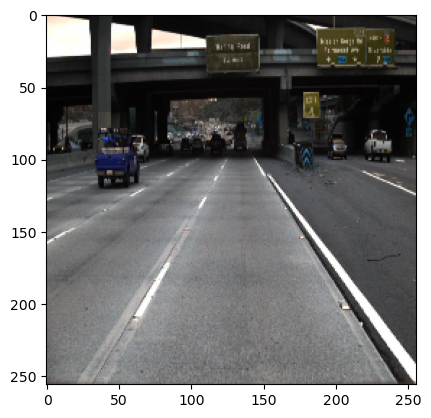

In [8]:
img2 = X[2]
plt.imshow(img2)